In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
#import random 
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
import warnings

In [2]:
%matplotlib inline
#suppress warnings
warnings.filterwarnings('ignore')

All Required Functions:

In [3]:
def ConstructAllData(T):
    p=pd.read_csv(T,delim_whitespace=True)
    df_1       = pd.DataFrame(p)
    df = df_1.dropna()
    df_OtherHalf = df.rename(columns={'x': 'y','y': 'x'})
    df_1stq=df.append(df_OtherHalf)
    df_2ndq=df_1stq.copy()
    df_2ndq.x=df_2ndq.x*-1
    df_3rdq=df_2ndq.copy()
    df_3rdq.y=df_3rdq.y*-1
    df_4thq=df_1stq.copy()
    df_4thq.y=df_4thq.y*-1
    df_Final=pd.concat([df_1stq, df_2ndq, df_3rdq,df_4thq],ignore_index=True)
    df_Final
    return df_Final

In [4]:
Quad="MagneticFieldFromQuad_ABSMagnetSystemGrid.txt"
SIM="MagneticFieldFromSIM_ABSMagnetSystemGrid.txt"
Ring="MagneticFieldFromRing_ABSMagnetSystemGrid.txt"

In [5]:
T_Quad=ConstructAllData(Quad)
T_SIM=ConstructAllData(SIM)
pr=pd.read_csv(Ring,delim_whitespace=True)
T_Ring1 = pd.DataFrame(pr)
T_Ring=T_Ring1.dropna()
T_Ring["r"]=T_Ring["r"]*100
T_Ring["z"]=T_Ring["z"]*100.

In [6]:
T_QS=T_Quad.copy()
T_QS
T_QS["Bxs"]=T_SIM["Bx"]
T_QS["Bys"]=T_SIM["By"]
T_QS["Bzs"]=T_SIM["Bz"]
T_QS["BTx"]=T_QS["Bx"]+T_QS["Bxs"]
T_QS["BTy"]=T_QS["By"]+T_QS["Bys"]
T_QS["BTz"]=T_QS["Bz"]+T_QS["Bzs"]
T_QS["x"]=T_QS["x"]*100
T_QS["y"]=T_QS["y"]*100
T_QS["z"]=T_QS["z"]*100

T_QS


,x,y,z,Bx,By,Bz,Bxs,Bys,Bzs,BTx,BTy,BTz
0,0.01,0.01,62.5,1.547712,-1.547712,0.000000e+00,0.075369,-0.075369,0.000000e+00,1.623081,-1.623081,0.000000e+00
1,0.21,0.01,62.5,32.988675,-1.606650,-7.268293e-01,1.549413,-0.074587,-5.628152e-02,34.538088,-1.681237,-7.831108e-01
2,0.41,0.01,62.5,64.383642,-1.568624,-2.769028e+00,3.023191,-0.071774,-2.198304e-01,67.406833,-1.640398,-2.988859e+00
3,0.61,0.01,62.5,95.946613,-1.692684,-6.243949e+00,4.497692,-0.076240,-4.841411e-01,100.444305,-1.768923,-6.728090e+00
4,0.81,0.01,62.5,127.633679,-1.697467,-1.101613e+01,5.967864,-0.074543,-8.511245e-01,133.601543,-1.772010,-1.186725e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
4992379,6.61,-6.81,249.7,-0.005898,0.005725,1.675587e-07,-0.001034,0.000799,4.714506e-07,-0.006932,0.006524,6.390093e-07
4992380,6.61,-7.01,249.7,-0.006070,0.005725,3.803395e-07,-0.000828,0.000828,0.000000e+00,-0.006898,0.006553,3.803395e-07
4992381,6.81,-6.81,249.7,-0.005898,0.005898,0.000000e+00,-0.000858,0.000828,5.352101e-08,-0.006756,0.006726,5.352101e-08
4992382,6.81,-7.01,249.7,-0.006070,0.005898,1.901697e-07,-0.000887,0.000828,1.106870e-07,-0.006957,0.006726,3.008567e-07


In [7]:
def ObtainB0_Ring(x,T_Ring):
    rt=(x[0]**2+x[1]**2)**0.5
    T_Ring["Del"]=((T_Ring["r"]-rt)**2+(T_Ring["z"]-x[2])**2)**0.5
    b=T_Ring["Del"].idxmin()
    a=T_Ring["Del"].min()
    if a>1.05:
        print("Not working as expected in Ring")
    Theta=math.atan2(x[1],x[0])
    Br=T_Ring.iloc[b]["Br"]
    Bz=T_Ring.iloc[b]["Bz"]
    B=[Br*np.cos(Theta),Br*np.sin(Theta),Bz]
    return B

In [8]:
def ObtainB0(x,T):
    T["Del"]=((T["x"]-x[0])**2+(T["y"]-x[1])**2+(T["z"]-x[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.1:
        print("Not working as expected in Quad /SIM ")
    B_Q=[T.iloc[b]["BTx"],T.iloc[b]["BTy"],T.iloc[b]["BTz"]]
    return B_Q

In [9]:
def CombineB0(x,T_QS,T_Ring):
    BQS=ObtainB0(x,T_QS)
    BR=ObtainB0_Ring(x,T_Ring)
    BT=[BQS[0]+BR[0],BQS[1]+BR[1],BQS[2]+BR[2]]
    return BT

In [10]:
#start work to calculate polarization
#intial parameters
g=20378.9; v3=22000;
z0=62.5;#initial position before exit of the quad
#z0=50;#try new one
r0=0.629;
z1=250;
r1=5;
num_points=100;
div=(r1+r0)/(z1-z0);

Pol=[]; 

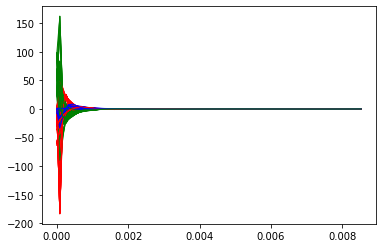

In [17]:
for n in range (1,num_points):
    
    phi = np.random.uniform(0,2*np.pi)
    #rho=-99;
    #while (abs(rho)>0.629):
    #    rho = np.random.normal(loc = 0, scale = 0.25, size = 1)*r0
    rho=np.sqrt(np.random.uniform(0,1))*r0
    x0=[ rho*np.cos(phi), rho*np.sin(phi), z0 ];
    
    B0=CombineB0(x0,T_QS,T_Ring);
    #obtain norm of the magnetic field
    B0t=np.linalg.norm(B0,axis=0);
    
    r=99999; 
    #make sure the generated values are within the radius of the pipe.
    while(r>r1):  
        ctheta=1-(1-np.cos(div))*np.random.uniform(0,1);
        v1=(v3*math.sqrt(1-pow(ctheta,2))*np.cos(phi), v3*math.sqrt(1-pow(ctheta,2))*np.sin(phi), v3*ctheta );
        x1=np.array(x0)
        v=np.array(v1)
        t1=(z1-z0)/v[2];
        x1=x0+(v*t1);
        #r=3;
        r2 = np.sqrt(x0[0]*x0[0] + x0[1]*x0[1]);
        r = np.sqrt(x1[0]*x1[0] + x1[1]*x1[1]);
    B1=CombineB0(x1,T_QS,T_Ring);
    B1t = np.linalg.norm(B1,axis=0);
   
    #print(x1)
    #plt.scatter(B1[0],x1[1])
    t_i=0
    #print(t1)
    initial_int=0;
    final_int=101;
    B1x=[];
    B1y=[];
    B1z=[];
    T_i=[];
    for t in range (initial_int, final_int,1):
        step=t1/(final_int-initial_int-1) #difference time /difference in range
        ti=t*step
        x_i=x0+(v*ti)
        B_i=CombineB0(x_i,T_QS,T_Ring);
        #print(B_i,x_i[2])
        T_i.append(ti)
        B1x.append(B_i[0])
        B1y.append(B_i[1])
        B1z.append(B_i[2])
    spl1 = UnivariateSpline(T_i,B1x)
    spl2 = UnivariateSpline(T_i,B1y)
    spl3 = UnivariateSpline(T_i,B1z)
    
    #plt.ylim([-5, 5])
    
    plt.plot(T_i, (spl2(T_i)), 'r', lw = 1)
    plt.plot(T_i, (spl3(T_i)), 'b', lw = 1)
    plt.plot(T_i, (spl1(T_i)), 'g', lw = 1)
    #spl1.set_smoothing_factor(1e-5)
    #spl2.set_smoothing_factor(1e-5)
    #spl3.set_smoothing_factor(1e-5)
    #Now solve the differential equation
    
    #sol = solve_ivp(lambda t, y: g*np.cross(y,  CombineCorrespondingMagneticField(x0,v,t,T_Quad,T_SIM,T_Ring)), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    sol = solve_ivp(lambda t, y: g*np.cross(y, [spl1(t),spl2(t),spl3(t)]), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    
    #obtain last elemet of the array from the ode solution
    Mx=sol.y[0][-1]
    My=sol.y[1][-1]
    Mz=sol.y[2][-1]
    #norm of output vector of the ode
    Mn=np.sqrt(Mx**2+My**2+Mz**2)
    
    #polarization is given by 
    pol=(B1[0]*Mx+B1[1]*My+B1[2]*Mz)/(Mn*B1t)
    Pol.append(pol)
    #print("finished "n" event")

<function matplotlib.pyplot.show(close=None, block=None)>

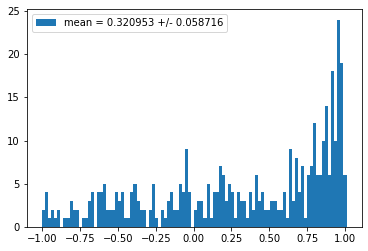

In [18]:
plt.hist(Pol,100,range=[-1.0,1.01]);
#plt.ylim([0, 130])
plt.legend(["mean = "+str("{:.6f}".format(np.mean(Pol)))+" +/- "+str("{:.6f}".format(np.std(Pol)/np.sqrt(num_points))) ] )
plt.show